# 2D case - Figures 9-10: FEM comparison
Two-parameter 2D problem - Comparison with the FEM reference and plot of the solution for different parametric configurations

## Libraries import  

In [22]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(9975355953847005664)

## Load the config file

In [23]:
    Configuration_file = 'Configurations/config_2D_ROM_SVK.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [24]:

# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )

# MaxElemSize2D = config["interpolation"]["MaxElemSize2D"] = 0.125
# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           224



## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [25]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]],
                                    [   config["parameters"]["para_2_min"],
                                        config["parameters"]["para_2_max"],
                                        config["parameters"]["N_para_2"]]])

## Initialisation of the surrogate model

In [26]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [27]:
ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

ROM_model.TrainingParameters(   
                                loss_decrease_c = config["training"]["loss_decrease_c"], 
                                Max_epochs = config["training"]["n_epochs"], 
                                learning_rate = config["training"]["learning_rate"]
                            )

ROM_model.train()                                                                   # Put the model in training mode
ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)         

# ROM_model.load_state_dict(torch.load('Pretrained_models/2D_ROM', weights_only=False))

* Refinement level: 0

**************** START TRAINING ***************

epoch 10 loss = 1.75057e-06 modes = 1
epoch 20 loss = 1.34384e-06 modes = 1
epoch 30 loss = 1.04358e-06 modes = 1
epoch 40 loss = 8.23916e-07 modes = 1
epoch 50 loss = 6.61838e-07 modes = 1
epoch 60 loss = 5.39637e-07 modes = 1
epoch 70 loss = 4.43772e-07 modes = 1
epoch 80 loss = 3.61649e-07 modes = 1
epoch 90 loss = 2.77682e-07 modes = 1
epoch 100 loss = 1.71076e-07 modes = 1
epoch 110 loss = 1.71956e-08 modes = 1
epoch 120 loss = -2.08271e-07 modes = 1
epoch 130 loss = -5.24390e-07 modes = 1
epoch 140 loss = -9.41115e-07 modes = 1
epoch 150 loss = -1.45816e-06 modes = 1
epoch 160 loss = -2.06755e-06 modes = 1
epoch 170 loss = -2.75922e-06 modes = 1
epoch 180 loss = -3.52685e-06 modes = 1
epoch 190 loss = -4.37016e-06 modes = 1
epoch 200 loss = -5.29277e-06 modes = 1
epoch 210 loss = -6.29967e-06 modes = 1
epoch 220 loss = -7.39642e-06 modes = 1
epoch 230 loss = -8.58999e-06 modes = 1
epoch 240 loss = -9.89026e-0

## Pyvista plots

Plot the solution 

In [28]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
import torch.nn as nn

pv.global_theme.font.family = 'times'                                           # Arial, courier or times
pv.global_theme.font.size = 40
pv.global_theme.font.title_size = 40
pv.global_theme.font.label_size = 40
pv.global_theme.font.fmt = '%.2e'

filename = 'Geometries/'+Mesh_object.name_mesh                                  # Load mesh (used for projecting the solution only) 
mesh = pv.read(filename)                                                        # Create pyvista mesh    
Nodes = np.stack(Mesh_object.Nodes)  
import matplotlib
matplotlib.rcParams["font.size"] = "25"


In [29]:
Mesh_object.NNodes

597

In [30]:
E_vect = [0.00038,0.0001,0.000462]
theta_vect = [4.21,0,0.82]

ROM_model.Space_modes[0].mesh.Nodes


eval_coord = torch.tensor(ROM_model.Space_modes[0].mesh.Nodes, dtype=torch.float64, requires_grad=True)[:,1:3]


## First parameters set

E = 0.00038, theta = 4.21, theta_deg = 241.21523175007655


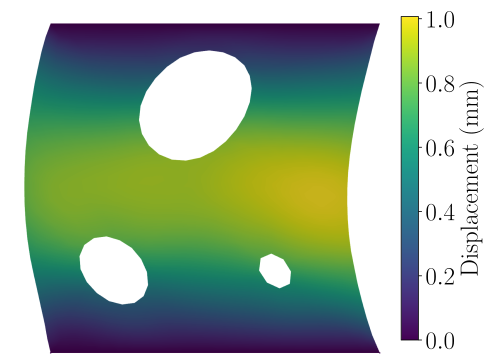

In [31]:
#Fig a)

name = 'SVK_a'

theta_i = theta_vect[0]
E_i = E_vect[0]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')


theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result a)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=1,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)


## Second parameters set

E = 0.0001, theta = 0, theta_deg = 0.0


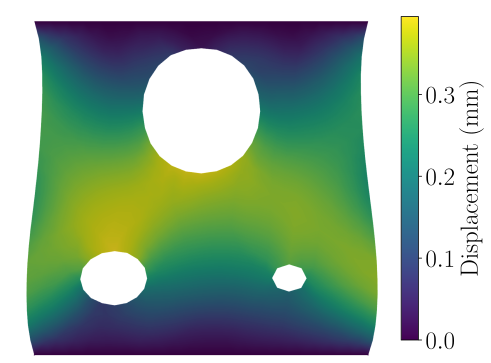

In [32]:
#Fig b)

name = 'SVK_b'

theta_i = theta_vect[1]
E_i = E_vect[1]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')



theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result b)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=1,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

   

## Third parameters set

E = 0.000462, theta = 0.82, theta_deg = 46.9825392007275


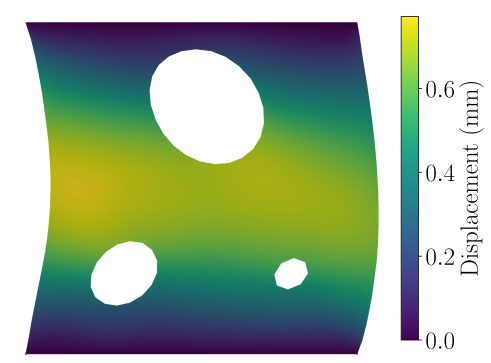

: 

In [33]:
#Fig c)

name = 'SVK_c'

theta_i = theta_vect[2]
E_i = E_vect[2]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')



theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result c)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=1,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)
